# **BUSINESS CASE 2: SIEMENS ADVANTA SALES FORECASTING**  


## 🎓 Master’s Program in Data Science & Advanced Analytics 
**Nova IMS** | March 2025   
**Course:** Business Cases with Data Science

## 👥 Team **Group A**  
- **Alice Viegas** | 20240572  
- **Bernardo Faria** | 20240579  
- **Dinis Pinto** | 20240612  
- **Daan van Holten** | 20240681
- **Philippe Dutranoit** | 20240518

## 📊 Goal of the notebook

in this notebook we make the build and test the models for forcasting <br>
<br>
=> for each product group
1. we fist evaluate the best model and the best hyper parameter, using grid_search, selected features from feeature selection and, actual data that was provided 
2. we make the prediction with the best model and best parameter 
3. we put the forcast in the test_set

=> we concate all the test set together

# Imports

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import itertools
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from prophet import Prophet


from Model_Functions import *

import importlib
imported_module = importlib.import_module("Model_Functions")
importlib.reload(imported_module)


<module 'Model_Functions' from '/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py'>

In [25]:
sales_agg1 = pd.read_csv('../data/sales_agg1.csv').set_index('DATE')
sales_agg3 = pd.read_csv('../data/sales_agg3.csv').set_index('DATE')
sales_agg4 = pd.read_csv('../data/sales_agg4.csv').set_index('DATE')
sales_agg5 = pd.read_csv('../data/sales_agg5.csv').set_index('DATE')
sales_agg6 = pd.read_csv('../data/sales_agg6.csv').set_index('DATE')
sales_agg8 = pd.read_csv('../data/sales_agg8.csv').set_index('DATE')
sales_agg9 = pd.read_csv('../data/sales_agg9.csv').set_index('DATE')
sales_agg11 = pd.read_csv('../data/sales_agg11.csv').set_index('DATE')
sales_agg12 = pd.read_csv('../data/sales_agg12.csv').set_index('DATE')
sales_agg13 = pd.read_csv('../data/sales_agg13.csv').set_index('DATE')
sales_agg14 = pd.read_csv('../data/sales_agg14.csv').set_index('DATE')
sales_agg16 = pd.read_csv('../data/sales_agg16.csv').set_index('DATE')
sales_agg20 = pd.read_csv('../data/sales_agg20.csv').set_index('DATE')
sales_agg36 = pd.read_csv('../data/sales_agg36.csv').set_index('DATE')

# extract the selected features list build in the feature selection step
selected_features_1 = pd.read_csv('../data/selected_features_1.csv')['selected_features'].tolist()
selected_features_3 = pd.read_csv('../data/selected_features_3.csv')['selected_features'].tolist()
selected_features_4 = pd.read_csv('../data/selected_features_4.csv')['selected_features'].tolist()
selected_features_5 = pd.read_csv('../data/selected_features_5.csv')['selected_features'].tolist()
selected_features_6 = pd.read_csv('../data/selected_features_6.csv')['selected_features'].tolist()
selected_features_8 = pd.read_csv('../data/selected_features_8.csv')['selected_features'].tolist()
selected_features_9 = pd.read_csv('../data/selected_features_9.csv')['selected_features'].tolist()
selected_features_11 = pd.read_csv('../data/selected_features_11.csv')['selected_features'].tolist()
selected_features_12 = pd.read_csv('../data/selected_features_12.csv')['selected_features'].tolist()
selected_features_13 = pd.read_csv('../data/selected_features_13.csv')['selected_features'].tolist()
selected_features_14 = pd.read_csv('../data/selected_features_14.csv')['selected_features'].tolist()
selected_features_16 = pd.read_csv('../data/selected_features_16.csv')['selected_features'].tolist()
selected_features_20 = pd.read_csv('../data/selected_features_20.csv')['selected_features'].tolist()
selected_features_36 = pd.read_csv('../data/selected_features_36.csv')['selected_features'].tolist()


# load the market data
df_market = pd.read_csv('../data/Market_data_predicted.csv').set_index('date')
test_set = pd.read_csv('../Data/Case2_Test Set Template.csv', sep=';')
print(sales_agg1.head())
df_market.head()


               Sales_EUR
DATE                    
2018-10-01  3.609892e+07
2018-11-01  3.699427e+07
2018-12-01  3.788961e+07
2019-01-01  2.772815e+07
2019-02-01  3.479316e+07


,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_SHP840,...,PRI27380_org,PRI27250_org,PRI27276_org,PRO28756_org,PRO28392_org,PRO271000_org,PRO27756_org,PRO27826_org,PRO27392_org,PRO27276_org
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,16.940704,16.940704,83.458866,109.334010,110.495272,86.074496,80.962532,111.353812,77.766367,90.442749,...,93.020027,96.864647,93.230453,96.177481,110.890034,91.390440,68.677657,120.706516,106.161262,85.913200
2004-03-01,23.711852,23.711852,106.168192,140.884616,144.686166,86.038258,80.912352,127.558608,77.829225,90.580357,...,93.540268,96.864653,93.335678,96.250927,141.176853,91.511498,68.452548,138.309550,140.288741,97.670815
2004-04-01,24.435235,24.435235,92.007646,105.853579,102.655769,85.997063,80.857863,108.732297,77.904642,90.751805,...,93.852425,96.864659,93.440903,96.330211,105.648765,91.666790,68.203892,115.557330,106.271197,87.253983
2004-05-01,23.708115,23.708115,85.696486,101.864777,100.305285,85.951483,80.800601,110.645200,77.993606,90.961426,...,93.852425,96.864666,93.546127,96.413549,101.990361,91.861457,67.936322,119.269534,101.608710,84.675552
2004-06-01,27.009138,27.009138,106.641482,120.332920,119.616380,85.902640,80.742724,122.020960,78.096995,91.213203,...,93.956467,96.864672,93.440903,96.499291,122.136575,92.100289,67.655734,128.849416,116.655248,95.401802


In [27]:
def parse_month_year(date_string):
    month_map = {
    "Jan": 1,
    "Feb": 2,
    "Mai": 5,
    "Jun": 6,
    "Jul": 7,
    "Aug": 8,
    "Sep": 9,
    "Okt": 10,
    "Nov": 11,
    "Dez": 12
    }

    month_abbr = date_string[:3]
    year_suffix = date_string[-2:]
    month_num = month_map.get(month_abbr)

    if not month_num:
        raise ValueError(f"Unknown month abbreviation: {month_abbr}")
    
    return datetime.strptime(f"{month_num} 01 {year_suffix}", "%m %d %y").date()
# Apply conversion safely
test_set['Month Year'] = test_set['Month Year'].apply(parse_month_year)

# Preparation 

## Create the lag market data feature needed for the model

In [10]:
df_market = create_lag_features(df_market, 6)
df_market.head()

/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagging[f'{col}_lag_{lag}'] = df_lagging[col].shift(lag)
/Users/philippedutranoit/document_ordi/nova/business_case_for_data_sciense/cases/BC_DA_Siemens/Notebooks/Model_Functions.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagging[f'{col}_lag_{lag}'] = df_lagging[col].shift(lag)
/Users/philippedutranoit/document_ordi/nova/business_case_for_data

,MAB_ELE_PRO156,MAB_ELE_SHP156,MAB_ELE_SHP250,MAB_ELE_PRO392,MAB_ELE_SHP392,MAB_ELE_PRO756,MAB_ELE_SHP756,MAB_ELE_PRO826,MAB_ELE_SHP826,MAB_ELE_SHP840,...,PRI27380_org_lag_6,PRI27250_org_lag_6,PRI27276_org_lag_6,PRO28756_org_lag_6,PRO28392_org_lag_6,PRO271000_org_lag_6,PRO27756_org_lag_6,PRO27826_org_lag_6,PRO27392_org_lag_6,PRO27276_org_lag_6
date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,16.940704,16.940704,83.458866,109.334010,110.495272,86.074496,80.962532,111.353812,77.766367,90.442749,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-01,23.711852,23.711852,106.168192,140.884616,144.686166,86.038258,80.912352,127.558608,77.829225,90.580357,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-04-01,24.435235,24.435235,92.007646,105.853579,102.655769,85.997063,80.857863,108.732297,77.904642,90.751805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-05-01,23.708115,23.708115,85.696486,101.864777,100.305285,85.951483,80.800601,110.645200,77.993606,90.961426,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-06-01,27.009138,27.009138,106.641482,120.332920,119.616380,85.902640,80.742724,122.020960,78.096995,91.213203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Define the parameter grid to run

In [ ]:
xgboost_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.3],
    'reg_alpha': [0, 0.1, 0.3],
    'reg_lambda': [0, 0.1, 0.3]
}

prophet_param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'yearly_seasonality': [True, False],
    'monthly_seasonality': [True, False],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
    'changepoint_prior_scale': [0.01, 0.1, 0.5]
}

# Product 1

In [12]:
# selecte only the features that are selected in the feature selection step
test_set_1 = test_set[test_set['Mapped_GCK'] == '#1']
df_market_1 = df_market[selected_features_1]
df_market_1.head()

,PRO27826_org_lag_1,PRO27826_org,MAB_ELE_PRO756_lag_1,PRI27380_org,PRO271000_org_lag_5,PRO27392_org_lag_3,PRO28392_org_lag_6
date,,,,,,,
2004-02-01,NaN,120.706516,NaN,93.020027,NaN,NaN,NaN
2004-03-01,120.706516,138.309550,86.074496,93.540268,NaN,NaN,NaN
2004-04-01,138.309550,115.557330,86.038258,93.852425,NaN,NaN,NaN
2004-05-01,115.557330,119.269534,85.997063,93.852425,NaN,106.161262,NaN
2004-06-01,119.269534,128.849416,85.951483,93.956467,NaN,140.288741,NaN


## Xgboost

In [13]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg1, df_market_1, train_size = 0.8)

X_val.info() 

xgboost_best_model_1, xgboost_best_params_1, xgboost_best_rmse_1 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_1)
print("Validation RMSE:", xgboost_best_rmse_1)


<class 'pandas.core.frame.DataFrame'>
Index: 9 entries, 2021-08-01 to 2022-04-01
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PRO27826_org_lag_1    9 non-null      float64
 1   PRO27826_org          9 non-null      float64
 2   MAB_ELE_PRO756_lag_1  9 non-null      float64
 3   PRI27380_org          9 non-null      float64
 4   PRO271000_org_lag_5   9 non-null      float64
 5   PRO27392_org_lag_3    9 non-null      float64
 6   PRO28392_org_lag_6    9 non-null      float64
dtypes: float64(7)
memory usage: 576.0+ bytes
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0} => RMSE: 3139955.7876, Relative RMSE: 0.0829
Params: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0.1} => RMSE: 3161485.3536

## Prophet

In [14]:
prophet_best_model_1, prophet_best_params_1, prophet_best_rmse_1 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_1)

print("Validation RMSE:", prophet_best_rmse_1)

19:42:08 - cmdstanpy - INFO - Chain [1] start processing
19:42:08 - cmdstanpy - INFO - Chain [1] done processing
19:42:08 - cmdstanpy - INFO - Chain [1] start processing
19:42:08 - cmdstanpy - INFO - Chain [1] done processing
19:42:08 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 5503348.8019, Relative RMSE: 0.1454
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 10118173.9628, Relative RMSE: 0.2673


19:42:08 - cmdstanpy - INFO - Chain [1] done processing
19:42:08 - cmdstanpy - INFO - Chain [1] start processing
19:42:08 - cmdstanpy - INFO - Chain [1] done processing
19:42:08 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 14585959.4522, Relative RMSE: 0.3853
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 17834572.8573, Relative RMSE: 0.4711


19:42:22 - cmdstanpy - INFO - Chain [1] done processing
19:42:22 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 42617755.7143, Relative RMSE: 1.1257


19:42:36 - cmdstanpy - INFO - Chain [1] done processing
19:42:36 - cmdstanpy - INFO - Chain [1] start processing
19:42:36 - cmdstanpy - INFO - Chain [1] done processing
19:42:36 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 39983941.2010, Relative RMSE: 1.0562
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 16756310.2723, Relative RMSE: 0.4426


19:42:48 - cmdstanpy - INFO - Chain [1] done processing
19:42:48 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 48628394.2484, Relative RMSE: 1.2845


19:43:01 - cmdstanpy - INFO - Chain [1] done processing
19:43:01 - cmdstanpy - INFO - Chain [1] start processing
19:43:01 - cmdstanpy - INFO - Chain [1] done processing
19:43:01 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 55715776.5224, Relative RMSE: 1.4717
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 5587228.6736, Relative RMSE: 0.1476


19:43:02 - cmdstanpy - INFO - Chain [1] done processing
19:43:02 - cmdstanpy - INFO - Chain [1] start processing
19:43:02 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 10109295.7400, Relative RMSE: 0.2670


19:43:02 - cmdstanpy - INFO - Chain [1] start processing
19:43:02 - cmdstanpy - INFO - Chain [1] done processing
19:43:02 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 14582884.2409, Relative RMSE: 0.3852
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 17801528.0934, Relative RMSE: 0.4702


19:43:13 - cmdstanpy - INFO - Chain [1] done processing
19:43:13 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 48968079.8583, Relative RMSE: 1.2935


19:43:25 - cmdstanpy - INFO - Chain [1] done processing
19:43:25 - cmdstanpy - INFO - Chain [1] start processing
19:43:25 - cmdstanpy - INFO - Chain [1] done processing
19:43:25 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 37037651.0248, Relative RMSE: 0.9783
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 16558112.6375, Relative RMSE: 0.4374


19:43:36 - cmdstanpy - INFO - Chain [1] done processing
19:43:36 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 45811121.9210, Relative RMSE: 1.2101


19:43:48 - cmdstanpy - INFO - Chain [1] done processing
19:43:48 - cmdstanpy - INFO - Chain [1] start processing
19:43:48 - cmdstanpy - INFO - Chain [1] done processing
19:43:48 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 68712759.7089, Relative RMSE: 1.8150
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3787710.5697, Relative RMSE: 0.1001


19:43:48 - cmdstanpy - INFO - Chain [1] done processing
19:43:48 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3787384.5013, Relative RMSE: 0.1000


19:43:48 - cmdstanpy - INFO - Chain [1] done processing
19:43:48 - cmdstanpy - INFO - Chain [1] start processing
19:43:48 - cmdstanpy - INFO - Chain [1] done processing
19:43:48 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3682155.5436, Relative RMSE: 0.0973
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 8057011.6086, Relative RMSE: 0.2128


19:43:49 - cmdstanpy - INFO - Chain [1] done processing
19:43:49 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 7692347.1117, Relative RMSE: 0.2032


19:43:49 - cmdstanpy - INFO - Chain [1] done processing
19:43:49 - cmdstanpy - INFO - Chain [1] start processing
19:43:49 - cmdstanpy - INFO - Chain [1] done processing
19:43:49 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 9532713.2895, Relative RMSE: 0.2518
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 8283645.5582, Relative RMSE: 0.2188


19:43:49 - cmdstanpy - INFO - Chain [1] done processing
19:43:49 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 7890956.8735, Relative RMSE: 0.2084


19:43:50 - cmdstanpy - INFO - Chain [1] done processing
19:43:50 - cmdstanpy - INFO - Chain [1] start processing
19:43:50 - cmdstanpy - INFO - Chain [1] done processing
19:43:50 - cmdstanpy - INFO - Chain [1] start processing
19:43:50 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 9728433.1384, Relative RMSE: 0.2570
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3787641.9395, Relative RMSE: 0.1000


19:43:50 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3789570.6226, Relative RMSE: 0.1001


19:43:50 - cmdstanpy - INFO - Chain [1] done processing
19:43:50 - cmdstanpy - INFO - Chain [1] start processing
19:43:50 - cmdstanpy - INFO - Chain [1] done processing
19:43:50 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3681982.2410, Relative RMSE: 0.0973
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 8032357.9068, Relative RMSE: 0.2122


19:43:50 - cmdstanpy - INFO - Chain [1] done processing
19:43:50 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 8405306.7856, Relative RMSE: 0.2220


19:43:51 - cmdstanpy - INFO - Chain [1] done processing
19:43:51 - cmdstanpy - INFO - Chain [1] start processing
19:43:51 - cmdstanpy - INFO - Chain [1] done processing
19:43:51 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 9543803.0328, Relative RMSE: 0.2521
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 8355816.4945, Relative RMSE: 0.2207


19:43:51 - cmdstanpy - INFO - Chain [1] done processing
19:43:51 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 8566558.6171, Relative RMSE: 0.2263


19:43:51 - cmdstanpy - INFO - Chain [1] done processing
19:43:51 - cmdstanpy - INFO - Chain [1] start processing
19:43:51 - cmdstanpy - INFO - Chain [1] done processing
19:43:51 - cmdstanpy - INFO - Chain [1] start processing
19:43:51 - cmdstanpy - INFO - Chain [1] done processing
19:43:51 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 9886883.0904, Relative RMSE: 0.2612
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4114839.9213, Relative RMSE: 0.1087
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4114734.4753, Relative RMSE: 0.1087


19:43:51 - cmdstanpy - INFO - Chain [1] done processing
19:43:51 - cmdstanpy - INFO - Chain [1] start processing
19:43:51 - cmdstanpy - INFO - Chain [1] done processing
19:43:52 - cmdstanpy - INFO - Chain [1] start processing
19:43:52 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 4335936.2044, Relative RMSE: 0.1145
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 4054388.3461, Relative RMSE: 0.1071


19:43:52 - cmdstanpy - INFO - Chain [1] start processing
19:43:52 - cmdstanpy - INFO - Chain [1] done processing
19:43:52 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 4157154.4672, Relative RMSE: 0.1098
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 4355096.4193, Relative RMSE: 0.1150


19:43:52 - cmdstanpy - INFO - Chain [1] done processing
19:43:52 - cmdstanpy - INFO - Chain [1] start processing
19:43:52 - cmdstanpy - INFO - Chain [1] done processing
19:43:52 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 4097154.5129, Relative RMSE: 0.1082
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 4158550.8677, Relative RMSE: 0.1098


19:43:52 - cmdstanpy - INFO - Chain [1] done processing
19:43:52 - cmdstanpy - INFO - Chain [1] start processing
19:43:52 - cmdstanpy - INFO - Chain [1] done processing
19:43:52 - cmdstanpy - INFO - Chain [1] start processing
19:43:52 - cmdstanpy - INFO - Chain [1] done processing
19:43:52 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 4354653.3870, Relative RMSE: 0.1150
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4114837.4124, Relative RMSE: 0.1087
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4114556.8089, Relative RMSE: 0.1087


19:43:53 - cmdstanpy - INFO - Chain [1] done processing
19:43:53 - cmdstanpy - INFO - Chain [1] start processing
19:43:53 - cmdstanpy - INFO - Chain [1] done processing
19:43:53 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 4331429.8657, Relative RMSE: 0.1144
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 4033253.2643, Relative RMSE: 0.1065


19:43:53 - cmdstanpy - INFO - Chain [1] done processing
19:43:53 - cmdstanpy - INFO - Chain [1] start processing
19:43:53 - cmdstanpy - INFO - Chain [1] done processing
19:43:53 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 4141162.7109, Relative RMSE: 0.1094
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 4355845.4438, Relative RMSE: 0.1151


19:43:53 - cmdstanpy - INFO - Chain [1] done processing
19:43:53 - cmdstanpy - INFO - Chain [1] start processing
19:43:53 - cmdstanpy - INFO - Chain [1] done processing
19:43:53 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 4088668.9442, Relative RMSE: 0.1080
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 4128217.7928, Relative RMSE: 0.1090


19:43:53 - cmdstanpy - INFO - Chain [1] done processing
19:43:53 - cmdstanpy - INFO - Chain [1] start processing
19:43:54 - cmdstanpy - INFO - Chain [1] done processing
19:43:54 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 4357342.3532, Relative RMSE: 0.1151
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3689104.1436, Relative RMSE: 0.0974


19:43:54 - cmdstanpy - INFO - Chain [1] done processing
19:43:54 - cmdstanpy - INFO - Chain [1] start processing
19:43:54 - cmdstanpy - INFO - Chain [1] done processing
19:43:54 - cmdstanpy - INFO - Chain [1] start processing
19:43:54 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3698558.5571, Relative RMSE: 0.0977
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3670820.0652, Relative RMSE: 0.0970


19:43:54 - cmdstanpy - INFO - Chain [1] start processing
19:43:54 - cmdstanpy - INFO - Chain [1] done processing
19:43:54 - cmdstanpy - INFO - Chain [1] start processing
19:43:54 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 3688992.3837, Relative RMSE: 0.0974
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 3698636.8288, Relative RMSE: 0.0977
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 3670185.5296, Relative RMSE: 0.0969


19:43:54 - cmdstanpy - INFO - Chain [1] start processing
19:43:54 - cmdstanpy - INFO - Chain [1] done processing
19:43:54 - cmdstanpy - INFO - Chain [1] start processing
19:43:54 - cmdstanpy - INFO - Chain [1] done processing
19:43:54 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 3700221.9203, Relative RMSE: 0.0977
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 3703571.6497, Relative RMSE: 0.0978


19:43:54 - cmdstanpy - INFO - Chain [1] done processing
19:43:54 - cmdstanpy - INFO - Chain [1] start processing
19:43:55 - cmdstanpy - INFO - Chain [1] done processing
19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:55 - cmdstanpy - INFO - Chain [1] done processing
19:43:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 3670053.3696, Relative RMSE: 0.0969
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841, Relative RMSE: 0.0974
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274, Relative RMSE: 0.0977


19:43:55 - cmdstanpy - INFO - Chain [1] done processing
19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:55 - cmdstanpy - INFO - Chain [1] done processing
19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:55 - cmdstanpy - INFO - Chain [1] done processing
19:43:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345, Relative RMSE: 0.0969
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841, Relative RMSE: 0.0974
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274, Relative RMSE: 0.0977


19:43:55 - cmdstanpy - INFO - Chain [1] done processing
19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:55 - cmdstanpy - INFO - Chain [1] done processing
19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:55 - cmdstanpy - INFO - Chain [1] done processing
19:43:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345, Relative RMSE: 0.0969
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841, Relative RMSE: 0.0974
Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274, Relative RMSE: 0.0977


19:43:55 - cmdstanpy - INFO - Chain [1] done processing
19:43:55 - cmdstanpy - INFO - Chain [1] start processing
19:43:56 - cmdstanpy - INFO - Chain [1] done processing
19:43:56 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'additive', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345, Relative RMSE: 0.0969
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 5841316.7623, Relative RMSE: 0.1543


19:43:56 - cmdstanpy - INFO - Chain [1] done processing
19:43:56 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 7789618.3984, Relative RMSE: 0.2058


19:44:10 - cmdstanpy - INFO - Chain [1] done processing
19:44:10 - cmdstanpy - INFO - Chain [1] start processing
19:44:10 - cmdstanpy - INFO - Chain [1] done processing
19:44:10 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 39450102.0490, Relative RMSE: 1.0421
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 17422697.5113, Relative RMSE: 0.4602


19:44:23 - cmdstanpy - INFO - Chain [1] done processing
19:44:23 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 51347156.6878, Relative RMSE: 1.3563


19:44:37 - cmdstanpy - INFO - Chain [1] done processing
19:44:37 - cmdstanpy - INFO - Chain [1] start processing
19:44:37 - cmdstanpy - INFO - Chain [1] done processing
19:44:38 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 55990228.8769, Relative RMSE: 1.4790
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 17116808.9911, Relative RMSE: 0.4521


19:44:51 - cmdstanpy - INFO - Chain [1] done processing
19:44:51 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 53137652.4297, Relative RMSE: 1.4036


19:45:05 - cmdstanpy - INFO - Chain [1] done processing
19:45:05 - cmdstanpy - INFO - Chain [1] start processing
19:45:06 - cmdstanpy - INFO - Chain [1] done processing
19:45:06 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 57560279.9345, Relative RMSE: 1.5204
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 5469356.5416, Relative RMSE: 0.1445


19:45:06 - cmdstanpy - INFO - Chain [1] done processing
19:45:06 - cmdstanpy - INFO - Chain [1] start processing
19:45:06 - cmdstanpy - INFO - Chain [1] done processing
19:45:06 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 7977471.9518, Relative RMSE: 0.2107
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 10485449.6173, Relative RMSE: 0.2770


19:45:06 - cmdstanpy - INFO - Chain [1] done processing
19:45:06 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 18132434.2306, Relative RMSE: 0.4790


19:45:18 - cmdstanpy - INFO - Chain [1] done processing
19:45:18 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 53707610.4314, Relative RMSE: 1.4187


19:45:30 - cmdstanpy - INFO - Chain [1] done processing
19:45:30 - cmdstanpy - INFO - Chain [1] start processing
19:45:30 - cmdstanpy - INFO - Chain [1] done processing
19:45:30 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 48661728.0999, Relative RMSE: 1.2854
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 17131215.0142, Relative RMSE: 0.4525


19:45:43 - cmdstanpy - INFO - Chain [1] done processing
19:45:43 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 55306283.1133, Relative RMSE: 1.4609


19:45:55 - cmdstanpy - INFO - Chain [1] done processing
19:45:55 - cmdstanpy - INFO - Chain [1] start processing
19:45:55 - cmdstanpy - INFO - Chain [1] done processing
19:45:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 54003582.3743, Relative RMSE: 1.4265
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3789578.4216, Relative RMSE: 0.1001


19:45:55 - cmdstanpy - INFO - Chain [1] done processing
19:45:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3795284.9156, Relative RMSE: 0.1003


19:45:55 - cmdstanpy - INFO - Chain [1] done processing
19:45:55 - cmdstanpy - INFO - Chain [1] start processing
19:45:55 - cmdstanpy - INFO - Chain [1] done processing
19:45:55 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3867574.5772, Relative RMSE: 0.1022
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 8174645.5164, Relative RMSE: 0.2159


19:45:56 - cmdstanpy - INFO - Chain [1] done processing
19:45:56 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 8754931.0134, Relative RMSE: 0.2313


19:46:08 - cmdstanpy - INFO - Chain [1] done processing
19:46:08 - cmdstanpy - INFO - Chain [1] start processing
19:46:08 - cmdstanpy - INFO - Chain [1] done processing
19:46:08 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 4767698.6688, Relative RMSE: 0.1259
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 8453335.6246, Relative RMSE: 0.2233


19:46:21 - cmdstanpy - INFO - Chain [1] done processing
19:46:21 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 8554713.3896, Relative RMSE: 0.2260


19:46:33 - cmdstanpy - INFO - Chain [1] done processing
19:46:33 - cmdstanpy - INFO - Chain [1] start processing
19:46:33 - cmdstanpy - INFO - Chain [1] done processing
19:46:33 - cmdstanpy - INFO - Chain [1] start processing
19:46:33 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 5597710.1049, Relative RMSE: 0.1479
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3684744.4937, Relative RMSE: 0.0973


19:46:33 - cmdstanpy - INFO - Chain [1] start processing
19:46:33 - cmdstanpy - INFO - Chain [1] done processing
19:46:33 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3681532.1269, Relative RMSE: 0.0972
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3607775.0477, Relative RMSE: 0.0953


19:46:33 - cmdstanpy - INFO - Chain [1] done processing
19:46:34 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 8001598.0331, Relative RMSE: 0.2114


19:46:34 - cmdstanpy - INFO - Chain [1] done processing
19:46:34 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 9024136.6634, Relative RMSE: 0.2384


19:46:34 - cmdstanpy - INFO - Chain [1] done processing
19:46:34 - cmdstanpy - INFO - Chain [1] start processing
19:46:34 - cmdstanpy - INFO - Chain [1] done processing
19:46:34 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 10583075.8762, Relative RMSE: 0.2795
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 8254398.5198, Relative RMSE: 0.2180


19:46:34 - cmdstanpy - INFO - Chain [1] done processing
19:46:34 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 8542672.0486, Relative RMSE: 0.2257


19:46:35 - cmdstanpy - INFO - Chain [1] done processing
19:46:35 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': True, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 10891279.0519, Relative RMSE: 0.2877


19:46:35 - cmdstanpy - INFO - Chain [1] done processing
19:46:35 - cmdstanpy - INFO - Chain [1] start processing
19:46:35 - cmdstanpy - INFO - Chain [1] done processing
19:46:35 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4001016.8600, Relative RMSE: 0.1057
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4043114.9092, Relative RMSE: 0.1068


19:46:35 - cmdstanpy - INFO - Chain [1] done processing
19:46:35 - cmdstanpy - INFO - Chain [1] start processing
19:46:35 - cmdstanpy - INFO - Chain [1] done processing
19:46:35 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 4231788.4106, Relative RMSE: 0.1118
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 3997836.6221, Relative RMSE: 0.1056


19:46:35 - cmdstanpy - INFO - Chain [1] done processing
19:46:35 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 4070528.2755, Relative RMSE: 0.1075


19:46:36 - cmdstanpy - INFO - Chain [1] done processing
19:46:36 - cmdstanpy - INFO - Chain [1] start processing
19:46:36 - cmdstanpy - INFO - Chain [1] done processing
19:46:36 - cmdstanpy - INFO - Chain [1] start processing
19:46:36 - cmdstanpy - INFO - Chain [1] done processing
19:46:36 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 3922568.5705, Relative RMSE: 0.1036
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 4081269.5130, Relative RMSE: 0.1078
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 4074304.7992, Relative RMSE: 0.1076


19:46:36 - cmdstanpy - INFO - Chain [1] done processing
19:46:36 - cmdstanpy - INFO - Chain [1] start processing
19:46:37 - cmdstanpy - INFO - Chain [1] done processing
19:46:37 - cmdstanpy - INFO - Chain [1] start processing
19:46:37 - cmdstanpy - INFO - Chain [1] done processing
19:46:37 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 9076969.6789, Relative RMSE: 0.2398
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 4047243.4286, Relative RMSE: 0.1069
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 4036535.4908, Relative RMSE: 0.1066


19:46:37 - cmdstanpy - INFO - Chain [1] done processing
19:46:37 - cmdstanpy - INFO - Chain [1] start processing
19:46:37 - cmdstanpy - INFO - Chain [1] done processing
19:46:37 - cmdstanpy - INFO - Chain [1] start processing
19:46:37 - cmdstanpy - INFO - Chain [1] done processing
19:46:37 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 4227560.4351, Relative RMSE: 0.1117
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 4067187.8862, Relative RMSE: 0.1074
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 4066757.3566, Relative RMSE: 0.1074


19:46:37 - cmdstanpy - INFO - Chain [1] done processing
19:46:37 - cmdstanpy - INFO - Chain [1] start processing
19:46:37 - cmdstanpy - INFO - Chain [1] done processing
19:46:37 - cmdstanpy - INFO - Chain [1] start processing
19:46:37 - cmdstanpy - INFO - Chain [1] done processing
19:46:37 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 4212299.8372, Relative RMSE: 0.1113
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 4067296.0591, Relative RMSE: 0.1074
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 4072332.8854, Relative RMSE: 0.1076


19:46:37 - cmdstanpy - INFO - Chain [1] done processing
19:46:37 - cmdstanpy - INFO - Chain [1] start processing
19:46:38 - cmdstanpy - INFO - Chain [1] done processing
19:46:38 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': True, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 4265524.0573, Relative RMSE: 0.1127
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3728069.8658, Relative RMSE: 0.0985


19:46:38 - cmdstanpy - INFO - Chain [1] done processing
19:46:38 - cmdstanpy - INFO - Chain [1] start processing
19:46:38 - cmdstanpy - INFO - Chain [1] done processing
19:46:38 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3705900.1783, Relative RMSE: 0.0979
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3656788.3159, Relative RMSE: 0.0966


19:46:38 - cmdstanpy - INFO - Chain [1] done processing
19:46:38 - cmdstanpy - INFO - Chain [1] start processing
19:46:38 - cmdstanpy - INFO - Chain [1] done processing
19:46:38 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 3671661.9633, Relative RMSE: 0.0970
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 3704101.7758, Relative RMSE: 0.0978


19:46:38 - cmdstanpy - INFO - Chain [1] done processing
19:46:38 - cmdstanpy - INFO - Chain [1] start processing
19:46:38 - cmdstanpy - INFO - Chain [1] done processing
19:46:38 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 3274042.5814, Relative RMSE: 0.0865
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 3754385.6601, Relative RMSE: 0.0992
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 3706528.1814, Relative RMSE: 0.0979


19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 3315835.4980, Relative RMSE: 0.0876
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841, Relative RMSE: 0.0974
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274, Relative RMSE: 0.0977


19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 0.1, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345, Relative RMSE: 0.0969
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841, Relative RMSE: 0.0974
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274, Relative RMSE: 0.0977


19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:40 - cmdstanpy - INFO - Chain [1] start processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345, Relative RMSE: 0.0969
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.01} => RMSE: 3689102.8841, Relative RMSE: 0.0974
Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.1} => RMSE: 3697621.0274, Relative RMSE: 0.0977


19:46:40 - cmdstanpy - INFO - Chain [1] done processing


Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': False, 'seasonality_prior_scale': 10.0, 'changepoint_prior_scale': 0.5} => RMSE: 3669936.6345, Relative RMSE: 0.0969
Best Params: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5}
Validation RMSE: 3274042.581357753


## Final prediction

19:49:23 - cmdstanpy - INFO - Chain [1] start processing


Best Model: Prophet
Best Parameters: {'seasonality_mode': 'multiplicative', 'yearly_seasonality': False, 'weekly_seasonality': False, 'daily_seasonality': True, 'seasonality_prior_scale': 1.0, 'changepoint_prior_scale': 0.5}
Best RMSE: 2381589.984644291


19:49:23 - cmdstanpy - INFO - Chain [1] done processing


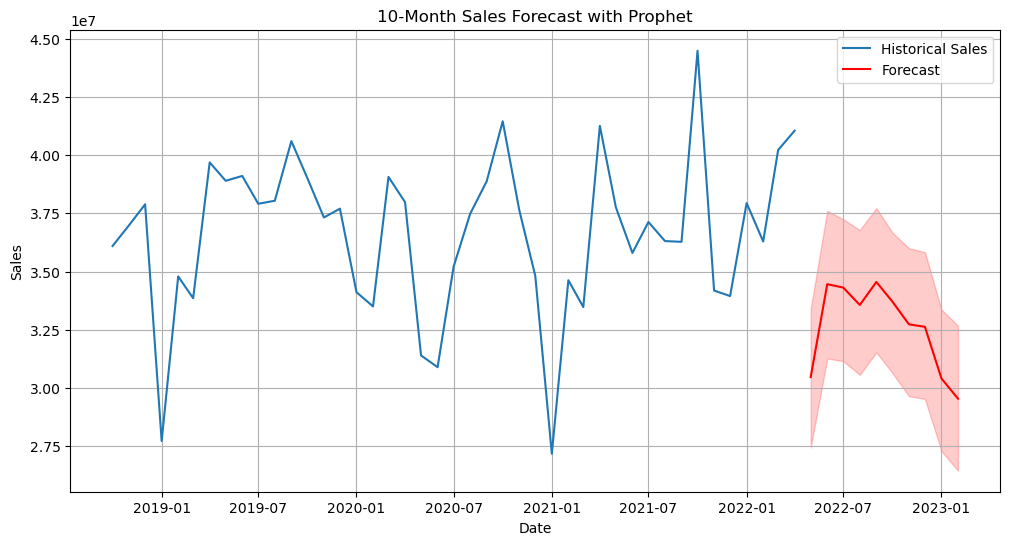

KeyError: "None of ['Month Year'] are in the columns"

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_1, prophet_best_params_1, prophet_best_rmse_1, "Prophet",
    xgboost_best_model_1, xgboost_best_params_1, xgboost_best_rmse_1, "XGBoost"
)
print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg1,
        df_market_1,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg1,
        df_market_1,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_1.set_index('Month Year', inplace = True)
test_set_1["Sales_EUR"] = results["yhat"]
test_set_1.reset_index(inplace = True)
test_set_1

# Product 3

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_3 = test_set[test_set['Mapped_GCK'] == '#3']
df_market_3 = df_market[selected_features_3]
df_market_3.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg3, df_market_3, train_size = 0.8)

X_val.info() 

xgboost_best_model_3, xgboost_best_params_3, xgboost_best_rmse_3 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_3)
print("Validation RMSE:", xgboost_best_rmse_3)

## Prophet

In [ ]:
prophet_best_model_3, prophet_best_params_3, prophet_best_rmse_3 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_3)

print("Validation RMSE:", prophet_best_rmse_3)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_3, prophet_best_params_3, prophet_best_rmse_3, "Prophet",
    xgboost_best_model_3, xgboost_best_params_3, xgboost_best_rmse_3, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg3,
        df_market_3,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg3,
        df_market_3,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_3.set_index('Month Year', inplace = True)
test_set_3["Sales_EUR"] = results["yhat"]
test_set_3

# Product 4

In [ ]:
test_set_4 = test_set[test_set['Mapped_GCK'] == '#4']
df_market_4 = df_market[selected_features_4]
df_market_4.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg4, df_market_4, train_size = 0.8)

X_val.info() 

xgboost_best_model_4, xgboost_best_params_4, xgboost_best_rmse_4 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_4)
print("Validation RMSE:", xgboost_best_rmse_4)

## Prophet

In [ ]:
prophet_best_model_4, prophet_best_params_4, prophet_best_rmse_4 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_4)

print("Validation RMSE:", prophet_best_rmse_4)

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_4, prophet_best_params_4, prophet_best_rmse_4, "Prophet",
    xgboost_best_model_4, xgboost_best_params_4, xgboost_best_rmse_4, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg4,
        df_market_4,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg4,
        df_market_4,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_4.set_index('Month Year', inplace = True)
test_set_4["Sales_EUR"] = results["yhat"]
test_set_4

# Product 5

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_5 = test_set[test_set['Mapped_GCK'] == '#5']
df_market_5 = df_market[selected_features_5]
df_market_5.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg5, df_market_5, train_size = 0.8)

X_val.info() 

xgboost_best_model_5, xgboost_best_params_5, xgboost_best_rmse_5 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_5)
print("Validation RMSE:", xgboost_best_rmse_5)

## Prophet

In [ ]:
prophet_best_model_5, prophet_best_params_5, prophet_best_rmse_5 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_5)

print("Validation RMSE:", prophet_best_rmse_5)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_5, prophet_best_params_5, prophet_best_rmse_5, "Prophet",
    xgboost_best_model_5, xgboost_best_params_5, xgboost_best_rmse_5, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg5,
        df_market_5,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg5,
        df_market_5,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_5.set_index('Month Year', inplace = True)
test_set_5["Sales_EUR"] = results["yhat"]
test_set_5

# Product 6

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_6 = test_set[test_set['Mapped_GCK'] == '#6']
df_market_6 = df_market[selected_features_6]
df_market_6.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg6, df_market_6, train_size = 0.8)

X_val.info() 

xgboost_best_model_6, xgboost_best_params_6, xgboost_best_rmse_6 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_6)
print("Validation RMSE:", xgboost_best_rmse_6)


## Prophet

In [ ]:
prophet_best_model_6, prophet_best_params_6, prophet_best_rmse_6 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_6)

print("Validation RMSE:", prophet_best_rmse_6)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_6, prophet_best_params_6, prophet_best_rmse_6, "Prophet",
    xgboost_best_model_6, xgboost_best_params_6, xgboost_best_rmse_6, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg6,
        df_market_6,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg6,
        df_market_6,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_6.set_index('Month Year', inplace = True)
test_set_6["Sales_EUR"] = results["yhat"]
test_set_6

# Product 8

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_8 = test_set[test_set['Mapped_GCK'] == '#8']
df_market_8 = df_market[selected_features_8]
df_market_8.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg8, df_market_8, train_size = 0.8)

X_val.info() 

xgboost_best_model_8, xgboost_best_params_8, xgboost_best_rmse_8 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_8)
print("Validation RMSE:", xgboost_best_rmse_8)

## Prophet

In [ ]:
prophet_best_model_8, prophet_best_params_8, prophet_best_rmse_8 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_8)

print("Validation RMSE:", prophet_best_rmse_8)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_8, prophet_best_params_8, prophet_best_rmse_8, "Prophet",
    xgboost_best_model_8, xgboost_best_params_8, xgboost_best_rmse_8, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg8,
        df_market_8,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg8,
        df_market_8,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_8.set_index('Month Year', inplace = True)
test_set_8["Sales_EUR"] = results["yhat"]
test_set_8

# Product 9

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_9 = test_set[test_set['Mapped_GCK'] == '#9']
df_market_9 = df_market[selected_features_9]
df_market_9.head()

## Xgboost 

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg9, df_market_9, train_size = 0.8)

X_val.info() 

xgboost_best_model_9, xgboost_best_params_9, xgboost_best_rmse_9 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_9)
print("Validation RMSE:", xgboost_best_rmse_9)

## Prophet

In [ ]:
prophet_best_model_9, prophet_best_params_9, prophet_best_rmse_9 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_9)

print("Validation RMSE:", prophet_best_rmse_9)

## Final prediction 

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_9, prophet_best_params_9, prophet_best_rmse_9, "Prophet",
    xgboost_best_model_9, xgboost_best_params_9, xgboost_best_rmse_9, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg9,
        df_market_9,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg9,
        df_market_9,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_9.set_index('Month Year', inplace = True)
test_set_9["Sales_EUR"] = results["yhat"]
test_set_9

# Product 11

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_11 = test_set[test_set['Mapped_GCK'] == '#11']
df_market_11 = df_market[selected_features_11]
df_market_11.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg11, df_market_11, train_size = 0.8)

X_val.info() 

xgboost_best_model_11, xgboost_best_params_11, xgboost_best_rmse_11 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_11)
print("Validation RMSE:", xgboost_best_rmse_11)

## Prophet

In [ ]:
prophet_best_model_11, prophet_best_params_11, prophet_best_rmse_11 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_11)

print("Validation RMSE:", prophet_best_rmse_11)

## Final prediction 

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_11, prophet_best_params_11, prophet_best_rmse_11, "Prophet",
    xgboost_best_model_11, xgboost_best_params_11, xgboost_best_rmse_11, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg11,
        df_market_11,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg11,
        df_market_11,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_11.set_index('Month Year', inplace = True)
test_set_11["Sales_EUR"] = results["yhat"]
test_set_11

# Product 12

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_12 = test_set[test_set['Mapped_GCK'] == '#12']
df_market_12 = df_market[selected_features_12]
df_market_12.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg12, df_market_12, train_size = 0.8)

X_val.info() 

xgboost_best_model_12, xgboost_best_params_12, xgboost_best_rmse_12 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_12)
print("Validation RMSE:", xgboost_best_rmse_12)

## Prophet

In [ ]:
prophet_best_model_12, prophet_best_params_12, prophet_best_rmse_12 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_12)

print("Validation RMSE:", prophet_best_rmse_12)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_12, prophet_best_params_12, prophet_best_rmse_12, "Prophet",
    xgboost_best_model_12, xgboost_best_params_12, xgboost_best_rmse_12, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg12,
        df_market_12,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg12,
        df_market_12,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_12.set_index('Month Year', inplace = True)
test_set_12["Sales_EUR"] = results["yhat"]
test_set_12

# Product 13

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_13 = test_set[test_set['Mapped_GCK'] == '#13']
df_market_13 = df_market[selected_features_13]
df_market_13.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg13, df_market_13, train_size = 0.8)

X_val.info() 

xgboost_best_model_13, xgboost_best_params_13, xgboost_best_rmse_13 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_13)
print("Validation RMSE:", xgboost_best_rmse_13)

## Prophet

In [ ]:
prophet_best_model_13, prophet_best_params_13, prophet_best_rmse_13 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_13)

print("Validation RMSE:", prophet_best_rmse_13)

## Final prediction 

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_13, prophet_best_params_13, prophet_best_rmse_13, "Prophet",
    xgboost_best_model_13, xgboost_best_params_13, xgboost_best_rmse_13, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg13,
        df_market_13,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg13,
        df_market_13,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_13.set_index('Month Year', inplace = True)
test_set_13["Sales_EUR"] = results["yhat"]
test_set_13

# Product 14

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_14 = test_set[test_set['Mapped_GCK'] == '#14']
df_market_14 = df_market[selected_features_14]
df_market_14.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg14, df_market_14, train_size = 0.8)

X_val.info() 

xgboost_best_model_14, xgboost_best_params_14, xgboost_best_rmse_14 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_14)
print("Validation RMSE:", xgboost_best_rmse_14)

## Prophet

In [ ]:
prophet_best_model_14, prophet_best_params_14, prophet_best_rmse_14 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_14)

print("Validation RMSE:", prophet_best_rmse_14)

## Final prediction 

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_14, prophet_best_params_14, prophet_best_rmse_14, "Prophet",
    xgboost_best_model_14, xgboost_best_params_14, xgboost_best_rmse_14, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg14,
        df_market_14,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg14,
        df_market_14,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_14.set_index('Month Year', inplace = True)
test_set_14["Sales_EUR"] = results["yhat"]
test_set_14

# Product 16

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_16 = test_set[test_set['Mapped_GCK'] == '#16']
df_market_16 = df_market[selected_features_16]
df_market_16.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg16, df_market_16, train_size = 0.8)

X_val.info() 

xgboost_best_model_16, xgboost_best_params_16, xgboost_best_rmse_16 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_16)
print("Validation RMSE:", xgboost_best_rmse_16)

## Prophet

In [ ]:
prophet_best_model_16, prophet_best_params_16, prophet_best_rmse_16 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_16)

print("Validation RMSE:", prophet_best_rmse_16)

## Final prediction 

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_16, prophet_best_params_16, prophet_best_rmse_16, "Prophet",
    xgboost_best_model_16, xgboost_best_params_16, xgboost_best_rmse_16, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg16,
        df_market_16,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg16,
        df_market_16,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_16.set_index('Month Year', inplace = True)
test_set_16["Sales_EUR"] = results["yhat"]
test_set_16

# Product 20

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_20 = test_set[test_set['Mapped_GCK'] == '#20']
df_market_20 = df_market[selected_features_20]
df_market_20.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg20, df_market_20, train_size = 0.8)

X_val.info() 

xgboost_best_model_20, xgboost_best_params_20, xgboost_best_rmse_20 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_20)
print("Validation RMSE:", xgboost_best_rmse_20)


## Prophet

In [ ]:
prophet_best_model_20, prophet_best_params_20, prophet_best_rmse_20 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_20)

print("Validation RMSE:", prophet_best_rmse_20)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_20, prophet_best_params_20, prophet_best_rmse_20, "Prophet",
    xgboost_best_model_20, xgboost_best_params_20, xgboost_best_rmse_20, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg20,
        df_market_20,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg20,
        df_market_20,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_20.set_index('Month Year', inplace = True)
test_set_20["Sales_EUR"] = results["yhat"]
test_set_20

# Product 36

In [ ]:
# selecte only the features that are selected in the feature selection step
test_set_36 = test_set[test_set['Mapped_GCK'] == '#36']
df_market_36 = df_market[selected_features_36]
df_market_36.head()

## Xgboost

In [ ]:
X_train, X_val, y_train, y_val = train_val_split(sales_agg36, df_market_36, train_size = 0.8)

X_val.info() 

xgboost_best_model_36, xgboost_best_params_36, xgboost_best_rmse_36 = model_evaluation_XGboost(X_train,
                                                                                             y_train, 
                                                                                             X_val, y_val, 
                                                                                             xgboost_param_grid)

print("Best Params:", xgboost_best_params_36)
print("Validation RMSE:", xgboost_best_rmse_36)


## Prophet

In [ ]:
prophet_best_model_36, prophet_best_params_36, prophet_best_rmse_36 = model_evaluation_prophet(X_train,
                                                                                             y_train, 
                                                                                             X_val, 
                                                                                             y_val, 
                                                                                             prophet_param_grid)

print("Best Params:", prophet_best_params_36)

print("Validation RMSE:", prophet_best_rmse_36)

## Final prediction

In [ ]:
best_model, best_params, best_rmse, best_model_name = select_best_model(
    prophet_best_model_36, prophet_best_params_36, prophet_best_rmse_36, "Prophet",
    xgboost_best_model_36, xgboost_best_params_36, xgboost_best_rmse_36, "XGBoost"
)

print(f"Best Model: {best_model_name}")
print("Best Parameters:", best_params)
print("Best RMSE:", best_rmse)

if best_model_name == "XGBoost":
    results = xgboost_forecast(
        sales_agg36,
        df_market_36,
        period=10,
        params =best_params,
    )
else:
    results = prophet_forecast(
        sales_agg36,
        df_market_36,
        period=10,
        param =best_params,
    )
results.set_index('ds',inplace = True)
test_set_36.set_index('Month Year', inplace = True)
test_set_36["Sales_EUR"] = results["yhat"]
test_set_36

# Exporting

In [ ]:


test_set = pd.concat([test_set_1, test_set_3, test_set_4, test_set_5, test_set_6, test_set_8, test_set_9,
                     test_set_11, test_set_12, test_set_13, test_set_14, test_set_16, test_set_20, test_set_36])

def revert_month_year(date_obj):
    reverse_month_map = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "Mai",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Okt",
        11: "Nov",
        12: "Dez"
    }
    # Format as e.g. "Jan20" (adjust the format if a space is needed)
    return f"{reverse_month_map[date_obj.month]} {date_obj.strftime('%y')}"

# Revert the conversion on the 'Month Year' column
test_set['Month Year'] = test_set['Month Year'].apply(revert_month_year)

test_set.to_csv('../data/test_set_predicted.csv', index=False)